# Remaining Useful Life Estimation

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.cluster import KMeans
import xgboost as xgb
from joblib import dump, load

# Load data

In [5]:
degradationData = pd.read_csv('train_FD002.txt', sep=' ', header=None,
                  names=['op_setting_1','op_setting_2','op_setting_3',
                        'sensor_1','sensor_2','sensor_3','sensor_4','sensor_5','sensor_6','sensor_7','sensor_8','sensor_9','sensor_10',
                        'sensor_11','sensor_12','sensor_13','sensor_14','sensor_15','sensor_16','sensor_17','sensor_18','sensor_19','sensor_20','sensor_21','sensor_22','sensor_23'])

degradationData.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 53759 entries, (1, 1) to (260, 316)
Data columns (total 26 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   op_setting_1  53759 non-null  float64
 1   op_setting_2  53759 non-null  float64
 2   op_setting_3  53759 non-null  float64
 3   sensor_1      53759 non-null  float64
 4   sensor_2      53759 non-null  float64
 5   sensor_3      53759 non-null  float64
 6   sensor_4      53759 non-null  float64
 7   sensor_5      53759 non-null  float64
 8   sensor_6      53759 non-null  float64
 9   sensor_7      53759 non-null  float64
 10  sensor_8      53759 non-null  float64
 11  sensor_9      53759 non-null  float64
 12  sensor_10     53759 non-null  float64
 13  sensor_11     53759 non-null  float64
 14  sensor_12     53759 non-null  float64
 15  sensor_13     53759 non-null  float64
 16  sensor_14     53759 non-null  float64
 17  sensor_15     53759 non-null  float64
 18  sensor_16     53

In [6]:
## drop columns
degradationData.drop(['sensor_22','sensor_23'], axis=1, inplace=True)
degradationData.reset_index(inplace=True)
degradationData.rename(columns={'level_0':'id', 'level_1':'time'}, inplace=True)
degradationData.head()

id  time  op_setting_1  op_setting_2  op_setting_3  sensor_1  sensor_2  \
0   1     1       34.9983        0.8400         100.0    449.44    555.32   
1   1     2       41.9982        0.8408         100.0    445.00    549.90   
2   1     3       24.9988        0.6218          60.0    462.54    537.31   
3   1     4       42.0077        0.8416         100.0    445.00    549.51   
4   1     5       25.0005        0.6203          60.0    462.54    537.07   

   sensor_3  sensor_4  sensor_5  ...  sensor_12  sensor_13  sensor_14  \
0   1358.61   1137.23      5.48  ...     183.06    2387.72    8048.56   
1   1353.22   1125.78      3.91  ...     130.42    2387.66    8072.30   
2   1256.76   1047.45      7.05  ...     164.22    2028.03    7864.87   
3   1354.03   1126.38      3.91  ...     130.72    2387.61    8068.66   
4   1257.71   1047.93      7.05  ...     164.31    2028.00    7861.23   

   sensor_15  sensor_16  sensor_17  sensor_18  sensor_19  sensor_20  sensor_21  
0     9.3461       0.02        334       2223     100.00      14.73     8.8071  
1     9.3774       0.02        330       2212     100.00      10.41     6.2665  
2    10.8941       0.02        309       1915      84.93      14.08     8.6723  
3     9.3528       0.02        329       2212     100.00      10.59     6.4701  
4    10.8963       0.02        309       1915      84.93      14.13     8.5286  

[5 rows x 26 columns]

# Spit traning data validation

In [7]:
trainData = degradationData[degradationData.id <= 175].copy()
validationData = degradationData[degradationData.id > 175].copy()
trainData.shape, validationData.shape

((36608, 26), (17151, 26))

In [65]:
validationData.drop(['cluster'], axis=1).to_csv('test_data.csv', index=False)

In [8]:
# get columns
varNames = degradationData.columns.values
timeVariable = varNames[1]
conditionVariables = varNames[2:5]
dataVariables = varNames[5:]
timeVariable, conditionVariables, dataVariables

('time',
 array(['op_setting_1', 'op_setting_2', 'op_setting_3'], dtype=object),
 array(['sensor_1', 'sensor_2', 'sensor_3', 'sensor_4', 'sensor_5',
        'sensor_6', 'sensor_7', 'sensor_8', 'sensor_9', 'sensor_10',
        'sensor_11', 'sensor_12', 'sensor_13', 'sensor_14', 'sensor_15',
        'sensor_16', 'sensor_17', 'sensor_18', 'sensor_19', 'sensor_20',
        'sensor_21'], dtype=object))

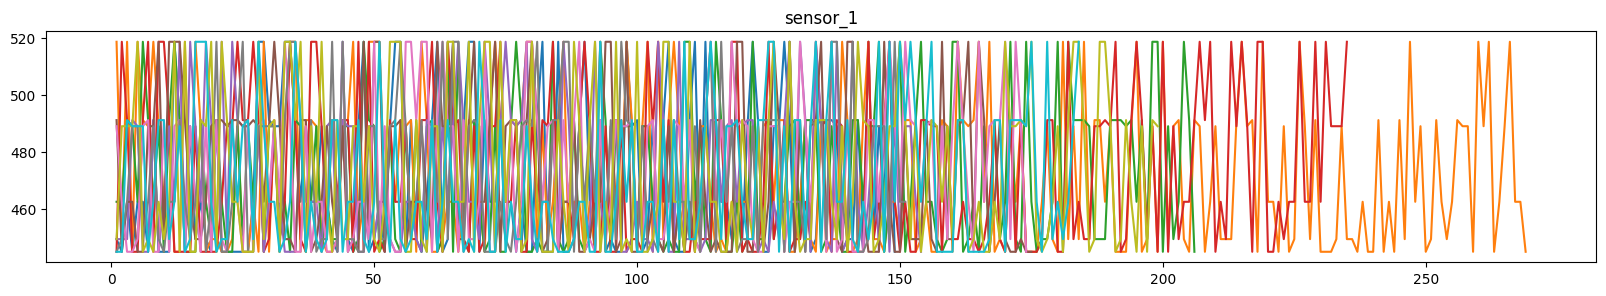

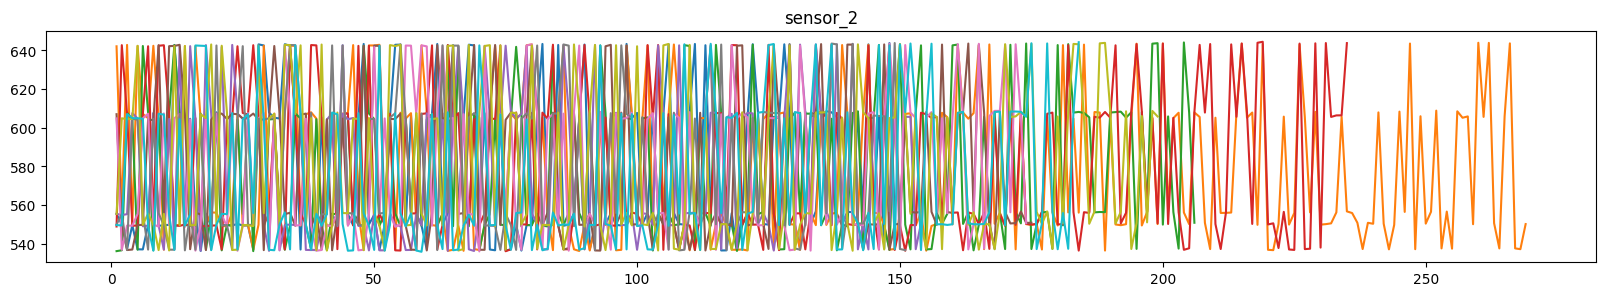

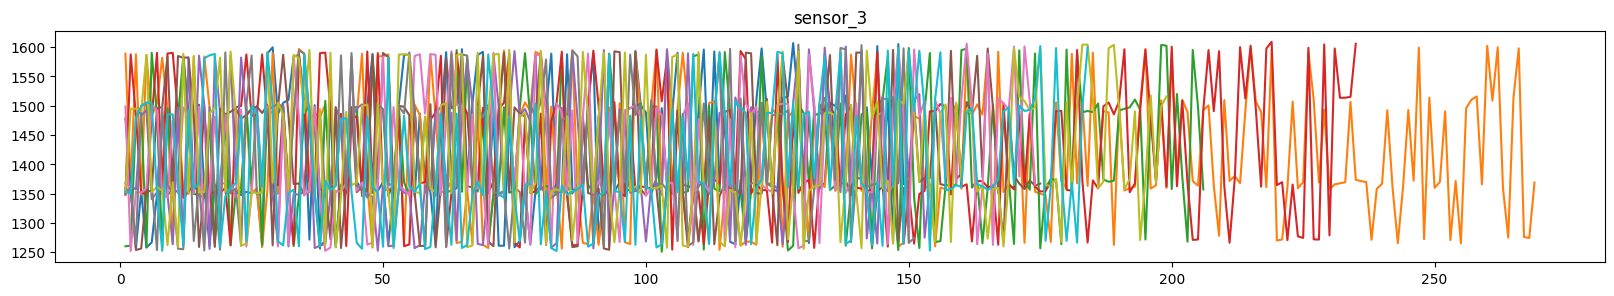

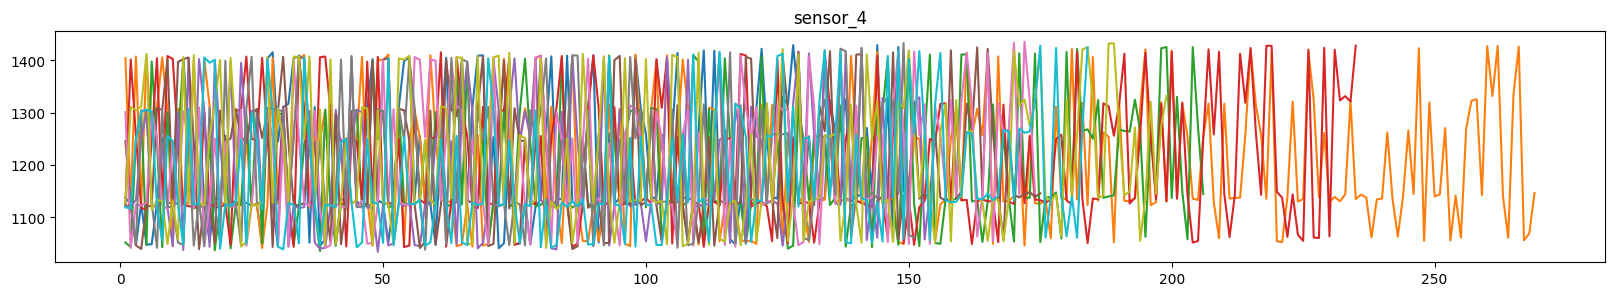

In [9]:
def vis_data(data,list_sensor,nsample):
    '''
    list_sensor: name of columns to visualize
    nsample: number of  ensembles data.
    '''
    start = data.id.unique()[0]
    for x in list_sensor:
        fig = plt.figure(figsize=(20,3))
        plt.title(x)
        
        for i in range(start,start+nsample):
            plt.plot(data[data.id == i].time, data[data.id == i][x])
        plt.show()
    
vis_data(trainData,['sensor_1','sensor_2','sensor_3','sensor_4'],10)

## Clustering 

In [10]:
opCondition = trainData[conditionVariables] # get operating conditions

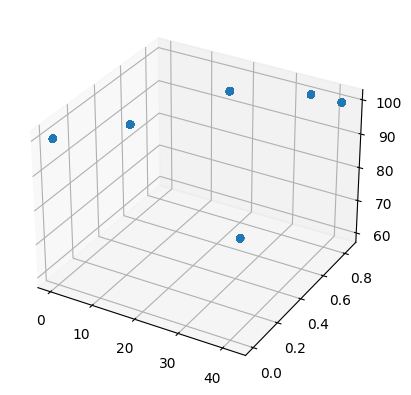

In [11]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(opCondition['op_setting_1'],opCondition['op_setting_2'],opCondition['op_setting_3'])
plt.show()

In [12]:
model_kmeans = KMeans(n_clusters=6, n_init=10,random_state = 0)
model_kmeans.fit(opCondition)
y_means = model_kmeans.predict(opCondition)

In [16]:
# save model kmeans
dump(model_kmeans,'model_kmeans.joblib')

['model_kmeans.joblib']

In [17]:
trainData['cluster'] = y_means
opCondition['cluster'] = y_means

/var/folders/7_/w3bs_ggj11x3s9d5_s01h_lc0000gn/T/ipykernel_2566/75624734.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  opCondition['cluster'] = y_means


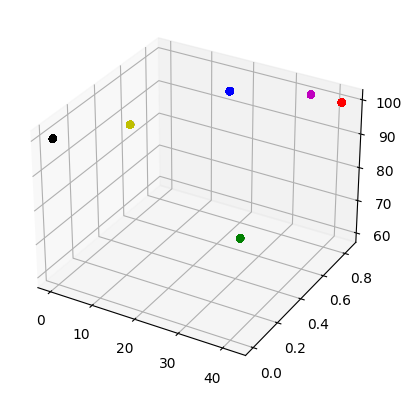

In [14]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

opCondition_plt = opCondition[opCondition.cluster == 0].copy()
ax.scatter(opCondition_plt['op_setting_1'],opCondition_plt['op_setting_2'],
           opCondition_plt['op_setting_3'], c='red', label='0')

opCondition_plt = opCondition[opCondition.cluster == 1].copy()
ax.scatter(opCondition_plt['op_setting_1'],opCondition_plt['op_setting_2'],
           opCondition_plt['op_setting_3'], c='blue', label='1')

opCondition_plt = opCondition[opCondition.cluster == 2].copy()
ax.scatter(opCondition_plt['op_setting_1'],opCondition_plt['op_setting_2'],
           opCondition_plt['op_setting_3'], c='green', label='1')

opCondition_plt = opCondition[opCondition.cluster == 3].copy()

ax.scatter(opCondition_plt['op_setting_1'], opCondition_plt['op_setting_2'],
           opCondition_plt['op_setting_3'], c='k', label='1')
opCondition_plt = opCondition[opCondition.cluster == 4].copy()

ax.scatter(opCondition_plt['op_setting_1'], opCondition_plt['op_setting_2'],
           opCondition_plt['op_setting_3'], c='y', label='1')
opCondition_plt = opCondition[opCondition.cluster == 5].copy()
ax.scatter(opCondition_plt['op_setting_1'], opCondition_plt['op_setting_2'],
           opCondition_plt['op_setting_3'], c='m', label='1')

plt.show()

# Normalization

In [39]:
def regimeNormalization(data):
    list_df = []
    Clusters = data.cluster.unique()
    for cluster in Clusters:
        each_cluster = data[data.cluster == cluster].copy()
        sc = StandardScaler()
        each_cluster.loc[:, dataVariables] = sc.fit_transform(each_cluster.loc[:,dataVariables])
        sc_model = f'sc_model_{cluster}.joblib'
        dump(sc, sc_model)
        list_df.append(each_cluster)
    res_df = pd.concat(list_df)
    res_df.sort_values(by = ['id','time'], inplace=True)
    return res_df

In [41]:
trainDataNormalized = regimeNormalization(trainData)
trainDataNormalized.head()

/var/folders/7_/w3bs_ggj11x3s9d5_s01h_lc0000gn/T/ipykernel_2566/3948042592.py:7: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  each_cluster.loc[:, dataVariables] = sc.fit_transform(each_cluster.loc[:,dataVariables])
/var/folders/7_/w3bs_ggj11x3s9d5_s01h_lc0000gn/T/ipykernel_2566/3948042592.py:7: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  each_cluster.loc[:, dataVariables] = sc.fit_transform(each_cluster.loc[:,dataVariables])
/var/folders/7_/w3bs_ggj11x3s9d5_s01h_lc0000gn/T/ipykernel_2566/3948042592.py:7: DeprecationWarning: In a future v

id  time  op_setting_1  op_setting_2  op_setting_3  sensor_1  sensor_2  \
0   1     1       34.9983        0.8400         100.0       0.0 -1.049946   
1   1     2       41.9982        0.8408         100.0       0.0  0.464414   
2   1     3       24.9988        0.6218          60.0       0.0  1.264393   
3   1     4       42.0077        0.8416         100.0       0.0 -0.427205   
4   1     5       25.0005        0.6203          60.0       0.0  0.593379   

   sensor_3  sensor_4      sensor_5  ...  sensor_13  sensor_14  sensor_15  \
0 -1.398221  0.789186 -8.881784e-16  ...  -1.450350  -1.588766   0.389890   
1 -0.194127 -0.228321  1.776357e-15  ...  -1.274089  -1.091773   0.102630   
2 -1.098780 -0.391473  1.776357e-15  ...  -1.062959  -1.074863  -0.426332   
3 -0.051374 -0.150028  1.776357e-15  ...  -1.432980  -1.319209  -0.543066   
4 -0.919418 -0.321444  1.776357e-15  ...  -1.171634  -1.355113  -0.375318   

      sensor_16  sensor_17  sensor_18     sensor_19  sensor_20  sensor_21  \
0  6.938894e-18  -0.138999        0.0  0.000000e+00  -0.909782  -1.360990   
1  0.000000e+00  -0.730790        0.0  0.000000e+00  -1.639366  -1.331787   
2  3.469447e-18   1.313241        0.0 -1.421085e-14  -1.658612   1.708013   
3  0.000000e+00  -1.437750        0.0  0.000000e+00   0.018773   1.830378   
4  3.469447e-18   1.313241        0.0 -1.421085e-14  -1.210646  -0.474588   

   cluster  
0        5  
1        0  
2        2  
3        0  
4        2  

[5 rows x 27 columns]

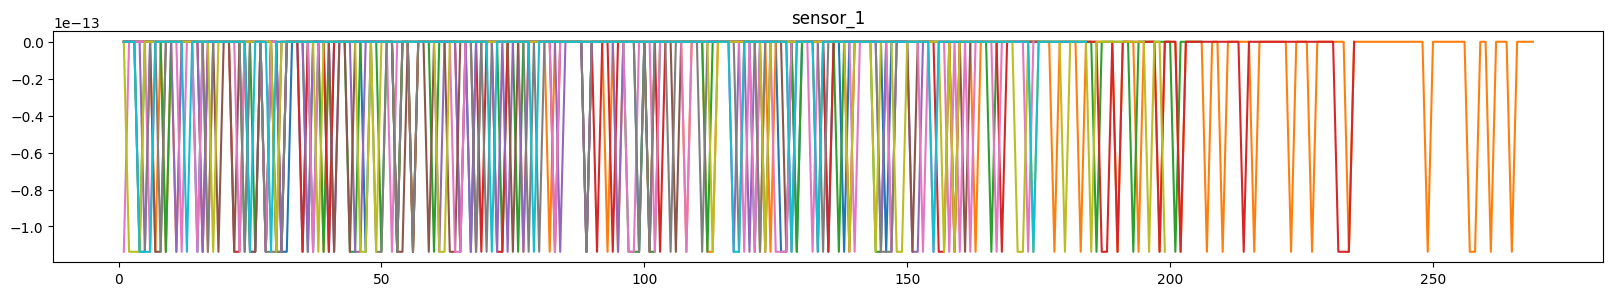

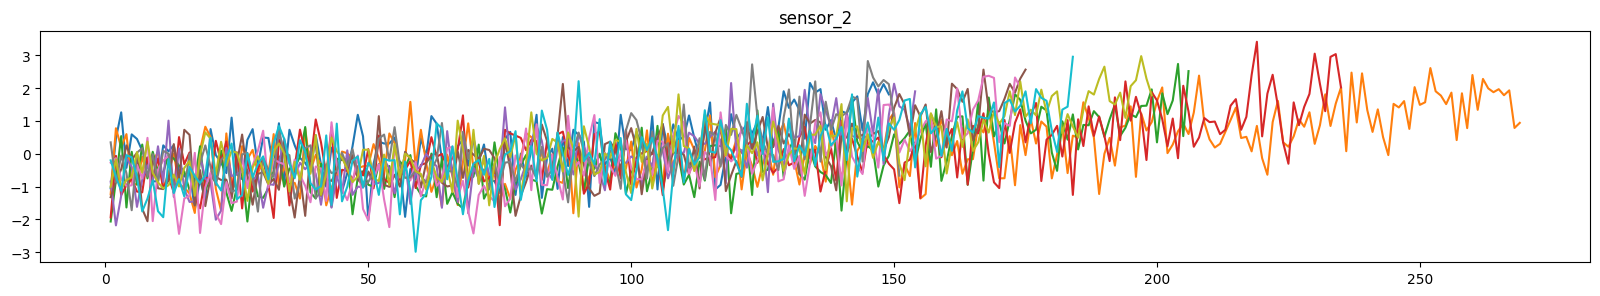

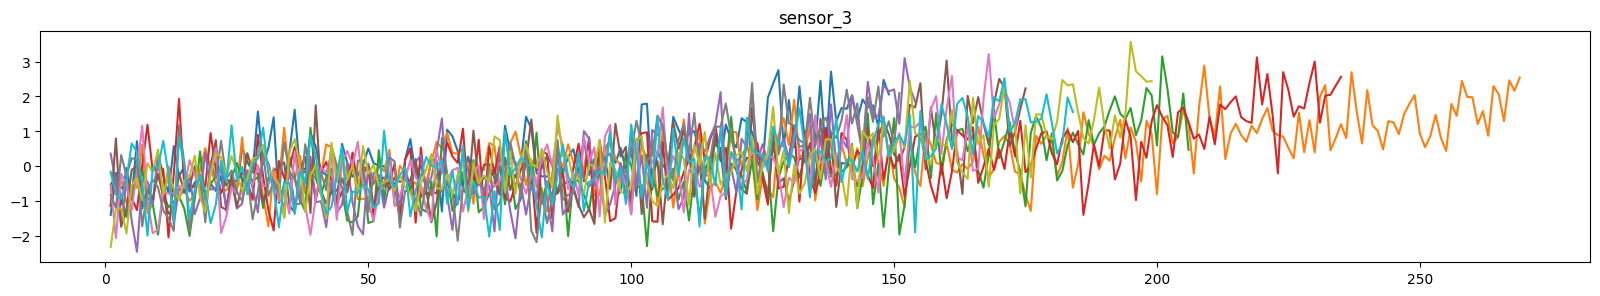

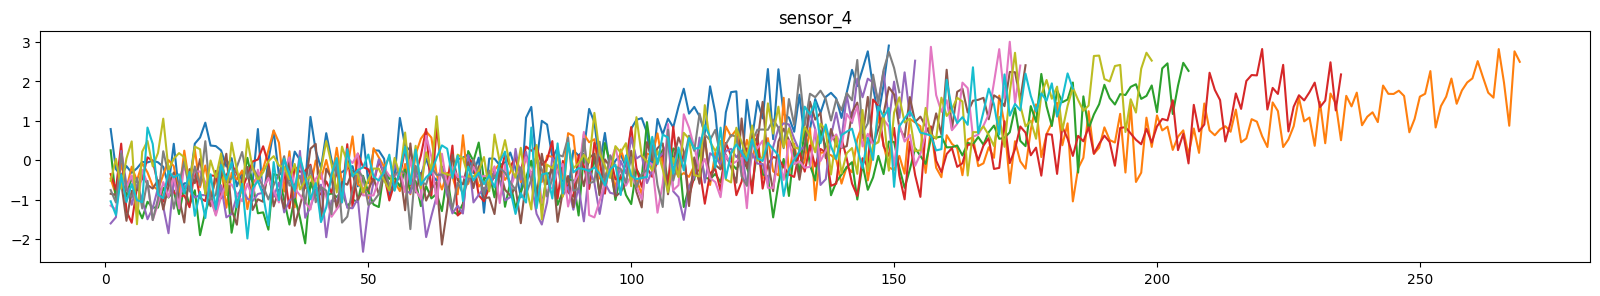

In [23]:
vis_data(trainDataNormalized,dataVariables[:4],10)

In [25]:
# make head indicator
ids = trainDataNormalized.id.unique()
list_df = []
for idx in ids:
    each_idx = trainDataNormalized[trainDataNormalized.id == idx].copy()
    rul = len(each_idx)
    each_idx['health'] = each_idx.apply(lambda x: (1 - (x.time*1.0/rul)) , axis=1)
    list_df.append(each_idx)
trainDataNormalized = pd.concat(list_df)
trainDataNormalized.head()

id  time  op_setting_1  op_setting_2  op_setting_3  sensor_1  sensor_2  \
0   1     1       34.9983        0.8400         100.0       0.0 -1.049946   
1   1     2       41.9982        0.8408         100.0       0.0  0.464414   
2   1     3       24.9988        0.6218          60.0       0.0  1.264393   
3   1     4       42.0077        0.8416         100.0       0.0 -0.427205   
4   1     5       25.0005        0.6203          60.0       0.0  0.593379   

   sensor_3  sensor_4      sensor_5  ...  sensor_14  sensor_15     sensor_16  \
0 -1.398221  0.789186 -8.881784e-16  ...  -1.588766   0.389890  6.938894e-18   
1 -0.194127 -0.228321  1.776357e-15  ...  -1.091773   0.102630  0.000000e+00   
2 -1.098780 -0.391473  1.776357e-15  ...  -1.074863  -0.426332  3.469447e-18   
3 -0.051374 -0.150028  1.776357e-15  ...  -1.319209  -0.543066  0.000000e+00   
4 -0.919418 -0.321444  1.776357e-15  ...  -1.355113  -0.375318  3.469447e-18   

   sensor_17  sensor_18     sensor_19  sensor_20  sensor_21  cluster    health  
0  -0.138999        0.0  0.000000e+00  -0.909782  -1.360990        5  0.993289  
1  -0.730790        0.0  0.000000e+00  -1.639366  -1.331787        0  0.986577  
2   1.313241        0.0 -1.421085e-14  -1.658612   1.708013        2  0.979866  
3  -1.437750        0.0  0.000000e+00   0.018773   1.830378        0  0.973154  
4   1.313241        0.0 -1.421085e-14  -1.210646  -0.474588        2  0.966443  

[5 rows x 28 columns]

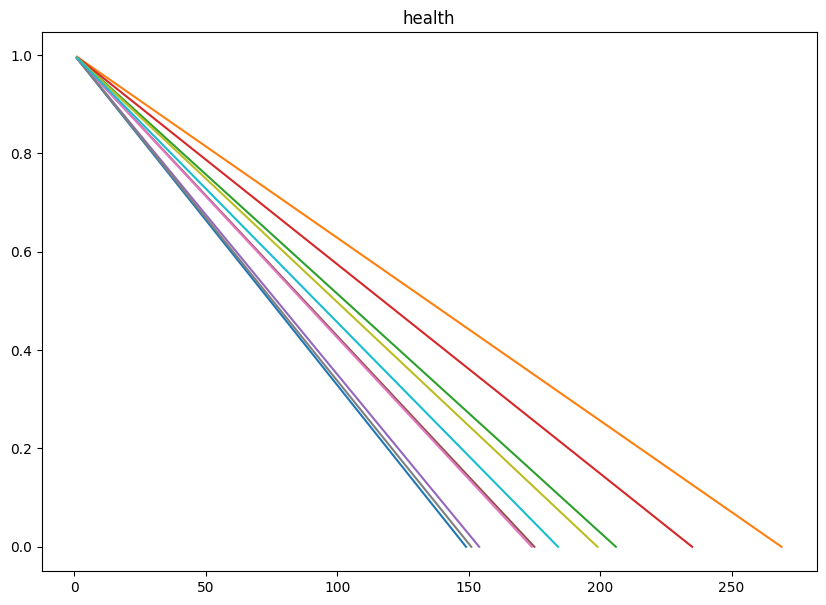

In [26]:
def vis_ensemble(data,list_sensor,nsample):
    start = data.id.unique()[0]
    for x in list_sensor:
        fig = plt.figure(figsize=(10,7))
        plt.title(x)
        for i in range(start,start+nsample):
            plt.plot(data[data.id == i].time, data[data.id == i][x])
        plt.show()
vis_ensemble(trainDataNormalized,['health'],10)

# Choose features

In [27]:
# Create model went choose columns sensor
#sensorToFuse = ['sensor_2','sensor_3','sensor_4','sensor_9','sensor_11','sensor_14','sensor_15','sensor_21'] // xgboots
sensorToFuse = ['sensor_2','sensor_3','sensor_4','sensor_7','sensor_11','sensor_12','sensor_15','sensor_17'] 
X = trainDataNormalized[sensorToFuse]
y = trainDataNormalized.health
regModel = LinearRegression()
regModel.fit(X,y)
weights = regModel.coef_
weights

array([-0.03144579, -0.02900143, -0.05151199,  0.00572367, -0.06626844,
        0.00568951, -0.04490592, -0.03622847])

In [68]:
with open('weights.npy','wb') as f:
    np.save(f, weights)

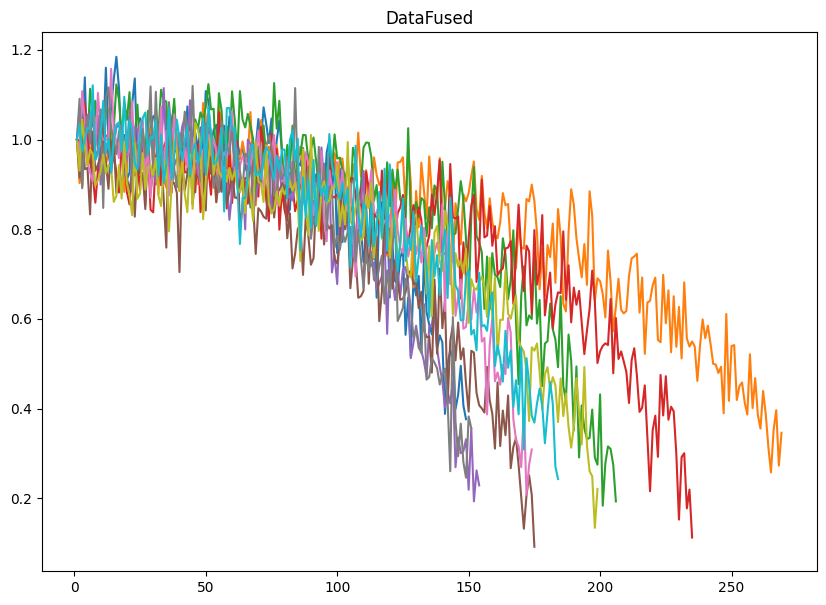

In [28]:
def degradationSensorFusion_notRolling(data, sensorToFuse, weights):
    dataFused = pd.DataFrame(data = np.sum(data[sensorToFuse]*weights, axis=1), columns = ['DataFused'])
    dataFused[['id','time']] = data[['id','time']].copy()
    ids = dataFused.id.unique()
    list_df = []
    for idx in ids:
        each_idx = dataFused[dataFused.id == idx].copy()
        each_idx['DataFused'] = each_idx['DataFused']
        neg = each_idx['DataFused'].values[0]
        each_idx['DataFused'] = each_idx['DataFused'] + 1 - neg
        list_df.append(each_idx)
    res_df = pd.concat(list_df)
    return res_df
trainDataFused = degradationSensorFusion_notRolling(trainDataNormalized, sensorToFuse, weights)
vis_ensemble(trainDataFused,['DataFused'],10)

In [29]:
def degradationSensorFusion(data, sensorToFuse, weights):
    dataFused = pd.DataFrame(data = np.sum(data[sensorToFuse]*weights, axis=1), columns = ['DataFused'])
    dataFused[['id','time']] = data[['id','time']].copy()
    ids = dataFused.id.unique()
    list_df = []
    for idx in ids:
        each_idx = dataFused[dataFused.id == idx].copy()
        each_idx['DataFused'] = each_idx['DataFused'].rolling(window=21, center=True, min_periods=0).mean()
        neg = each_idx['DataFused'].values[0]
        each_idx['DataFused'] = each_idx['DataFused'] + 1 - neg
        list_df.append(each_idx)
    res_df = pd.concat(list_df)
    return res_df
trainDataFused = degradationSensorFusion(trainDataNormalized, sensorToFuse, weights)

In [70]:
trainDataFused.to_csv('trainDataFused.csv', index=False)

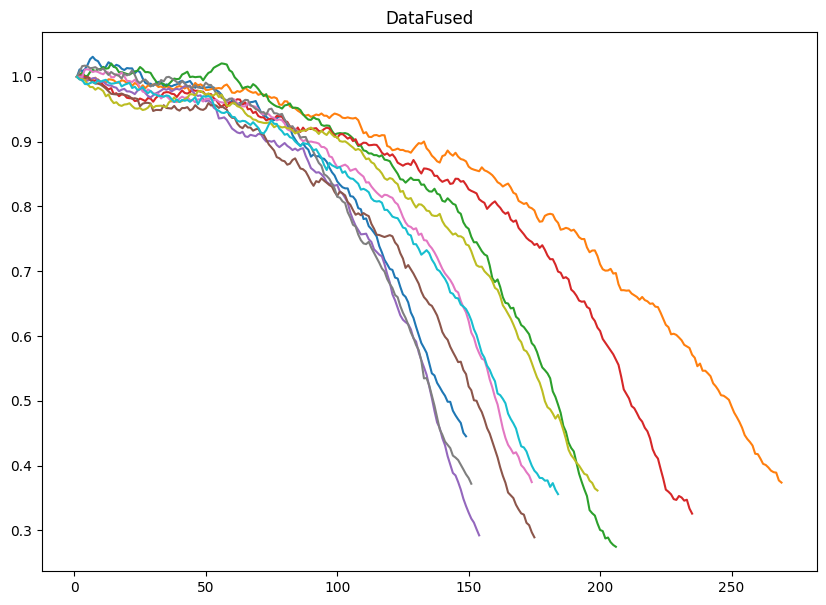

In [35]:
vis_ensemble(trainDataFused,['DataFused'],10)

# Apply same operation to validation data

In [36]:
#Predict columns for validation data
opCondition_var = validationData[conditionVariables]
y_means_var = model_kmeans.predict(opCondition_var)
validationData['cluster'] = y_means_var

In [45]:
def load_Normalization(data):
    list_df = []
    Clusters = data.cluster.unique()
    for cluster in Clusters:
        each_cluster = data[data.cluster == cluster].copy()
        sc_model = f'sc_model_{cluster}.joblib'
        sc = load(sc_model)
        each_cluster.loc[:, dataVariables] = sc.transform(each_cluster.loc[:,dataVariables])
        list_df.append(each_cluster)
    res_df = pd.concat(list_df)
    res_df.sort_values(by = ['id','time'], inplace=True)
    return res_df

In [46]:
validationDataNormalized = load_Normalization(validationData)

/var/folders/7_/w3bs_ggj11x3s9d5_s01h_lc0000gn/T/ipykernel_2566/368166993.py:8: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  each_cluster.loc[:, dataVariables] = sc.transform(each_cluster.loc[:,dataVariables])
/var/folders/7_/w3bs_ggj11x3s9d5_s01h_lc0000gn/T/ipykernel_2566/368166993.py:8: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  each_cluster.loc[:, dataVariables] = sc.transform(each_cluster.loc[:,dataVariables])
/var/folders/7_/w3bs_ggj11x3s9d5_s01h_lc0000gn/T/ipykernel_2566/368166993.py:8: DeprecationWarning: In a future version, `df

In [47]:
validataionDataToFused = degradationSensorFusion(validationDataNormalized, sensorToFuse, weights)

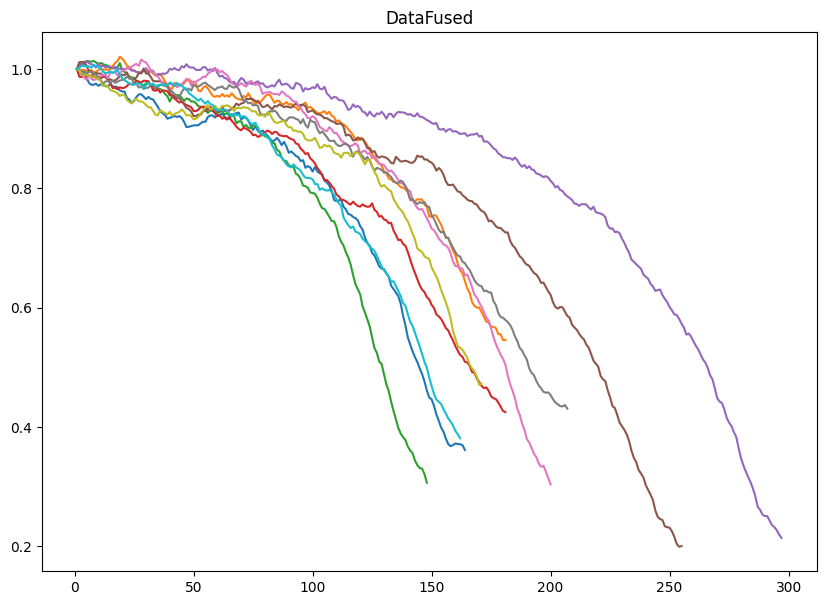

In [48]:
vis_ensemble(validataionDataToFused,['DataFused'],10)

## Build Similarity RUL Model

## test model 2nd order polynomial

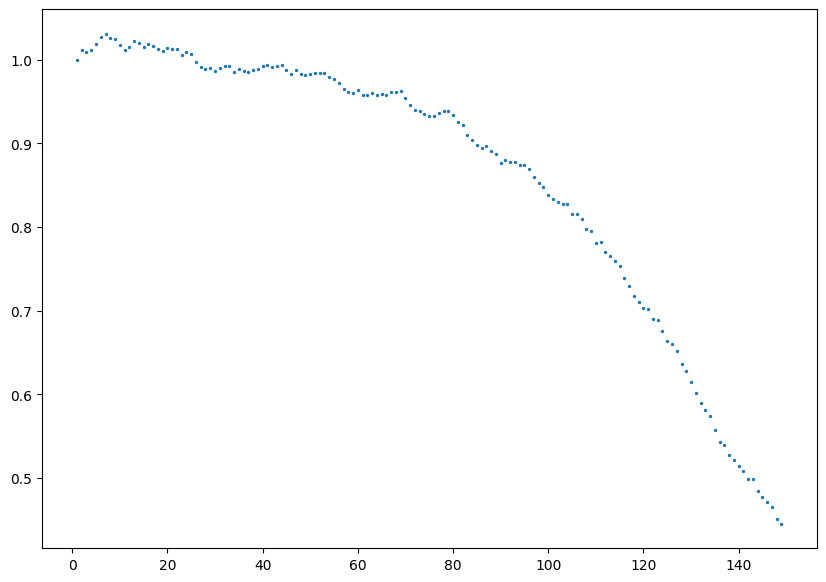

In [49]:
trainDataFused_1 = trainDataFused[trainDataFused.id == 1].copy()
fig = plt.figure(figsize=(10,7))
plt.scatter(trainDataFused_1.time, trainDataFused_1.DataFused, s=2)

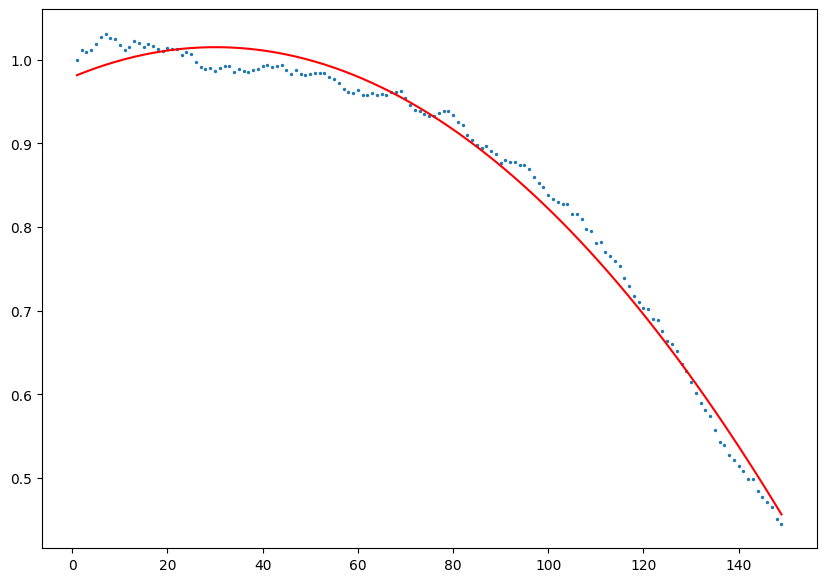

In [50]:
# fit data with a 2nd order polynomial.
p = np.polyfit(trainDataFused_1.time, trainDataFused_1.DataFused, 2)

fig = plt.figure(figsize=(10,7))
plt.scatter(trainDataFused_1.time, trainDataFused_1.DataFused, s=2, label='Train Data')
plt.plot(trainDataFused_1.time,np.polyval(p,trainDataFused_1.time), c='r', label='best fit 2nd polynomial')

### Apply same operation to validation data

In [51]:
class residualSimilarityModel:
    
    def __init__(self):
        self.df_model = pd.DataFrame(columns = ['id','lifeSpan','poly'], index=None)
    
    def fit(self, dataTrain): # data train has many machines
        ids = dataTrain.id.unique()
        for idx in ids:
            each_id = dataTrain[dataTrain.id == idx].copy()
            poly = np.polyfit(each_id.time, each_id.DataFused, 2)
            self.df_model = self.df_model.append(pd.Series({
                'id':idx,
                'lifeSpan':each_id.time.values[-1],
                'poly':poly,
            }), ignore_index = True)
            
    def predictRUL(self, dataTest): # data test is a machine
        list_score = []
        for poly in self.df_model.poly:
            d_ij = np.linalg.norm(dataTest.DataFused - np.polyval(poly, dataTest.time),ord=1)
#            score = np.exp(-d_ij**2)
#             print(score)
            list_score.append(d_ij)
        
        df_pred = self.df_model[['id','lifeSpan']].copy()
        df_pred['score'] = list_score
        df_pred.sort_values(by = 'score',inplace=True)
        df_pred = df_pred[:50]
        
        estRUL = df_pred.lifeSpan.mean() - dataTest.time.max()
        ciRUL = [df_pred.lifeSpan.min(),df_pred.lifeSpan.max()]
        
        return estRUL, ciRUL, df_pred

In [52]:
class residualSimilarityModel_matrix:
    """
    This class is a model estimate of RUL
    
    .fit() training data 
    .predictRUL() to predict an estimate of RUL
    
    """
    def __init__(self):
        
        self.df_model = pd.DataFrame(columns = ['id','lifeSpan','poly'], index=None)
    
    def fit(self, dataTrain): # data train has many machines
        """
        Training data : fit each fused data with a 2nd order polynomial
        Params:
            dataTrain (DataFrane): fused training data
        """
        Ids = dataTrain.id.unique()
        for id in Ids:
            each_id = dataTrain[dataTrain.id == id].copy()
            poly = np.polyfit(each_id.time, each_id.DataFused, 2)
            self.df_model = self.df_model.append(pd.Series({
                'id':id,
                'lifeSpan':each_id.time.values[-1],
                'poly':poly,
            }), ignore_index = True)
            
    def predictRUL(self, dataTest): # data test is a machine
        
        """
        This method use to predict an estimate RUL 
        
        Params: 
            dataTest (DataFrame): a DataTest 
        return:
            estRUL (number) : a number estimate RUL
            ciRUL (list): range life Span min and life Span maxf
            df_pred (data frame)
        """
        df_pred = self.df_model.copy()
        # calculate distance 
        time = dataTest.time.values
        
        ## create a matrix each columns : x^2, x, 1 for  each time in dataTest
        mx_time = np.column_stack((time*time, time, np.ones(len(time)))) # x^2 + x + 1 
        mx_poly = np.column_stack(df_pred['poly'].values)
        
        # score = sum(abs( Y_j - Y'_ji )) 
        ## matrix multiplication to calculate Y'_ji 
        mx_predict = np.dot(mx_time, mx_poly)
        test_DataFused = dataTest.DataFused.values
        
        ## calcutate abs( Y_j - Y'_ji)
        list_score = abs(np.subtract(mx_predict.T, test_DataFused))
        list_score = list_score.sum(axis=1)
        df_pred['score'] = list_score
        
        df_pred.drop(columns=['poly'])
        
        # find top 100 min of similarity score
        df_pred.sort_values(by = 'score',inplace=True)
        df_pred = df_pred[:50]
        estRUL = df_pred.lifeSpan.mean() - dataTest.time.max()
        ciRUL = [df_pred.lifeSpan.min(),df_pred.lifeSpan.max()]
        
        return estRUL, ciRUL, df_pred

### Test an engine in validation

In [53]:
%%time
model = residualSimilarityModel_matrix()
model.fit(trainDataFused)
test = validataionDataToFused[validataionDataToFused.id == 176].copy()
trueRUL = test.time.max()
test = test[:int(test.time.max()*0.7)]
trueRUL -= test.time.max()
estRUL, ciRUL, df_predict = model.predictRUL(test)
estRUL

CPU times: user 132 ms, sys: 4.45 ms, total: 136 ms
Wall time: 138 ms


/var/folders/7_/w3bs_ggj11x3s9d5_s01h_lc0000gn/T/ipykernel_2566/3639703050.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.df_model = self.df_model.append(pd.Series({
/var/folders/7_/w3bs_ggj11x3s9d5_s01h_lc0000gn/T/ipykernel_2566/3639703050.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.df_model = self.df_model.append(pd.Series({
/var/folders/7_/w3bs_ggj11x3s9d5_s01h_lc0000gn/T/ipykernel_2566/3639703050.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.df_model = self.df_model.append(pd.Series({
/var/folders/7_/w3bs_ggj11x3s9d5_s01h_lc0000gn/T/ipykernel_2566/3639703050.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.con

58.360000000000014

In [54]:
df_test_pred = df_predict.sort_values(by = 'score', ascending=True)

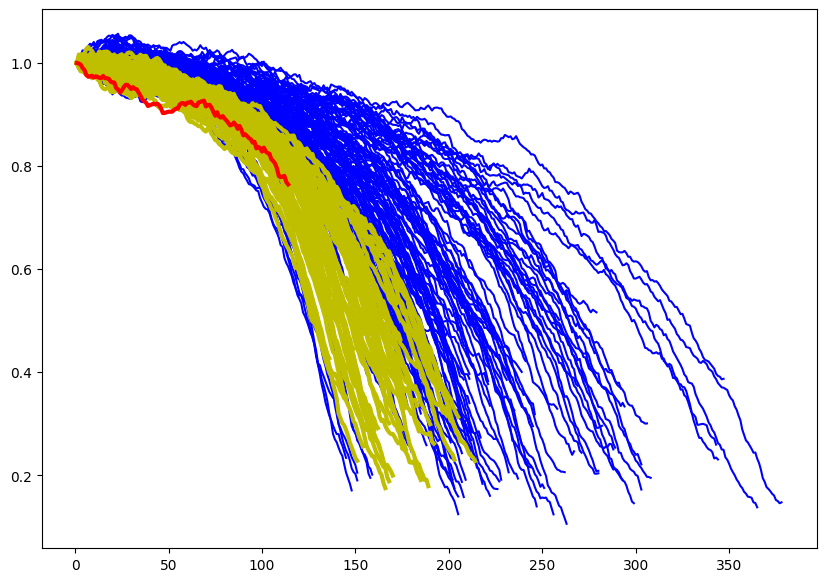

58.360000000000014

In [55]:
#visualization of predict model
fig = plt.figure(figsize =(10,7))
ids = trainDataFused.id.unique()
for idx in  ids:
    each_id = trainDataFused[trainDataFused.id == idx].copy()
    plt.plot(each_id.time, each_id.DataFused, c='b')
for idx in df_test_pred.id:
    each_id = trainDataFused[trainDataFused.id == idx].copy()
    plt.plot(each_id.time, each_id.DataFused, c='y',linewidth=3)
plt.plot(test.time,test.DataFused,c='r',linewidth=3)
plt.show()
estRUL

In [56]:
%%time
breakpoint = {'err_5': 0.5, 'err_7': 0.7 , 'err_9': 0.9}

error_matrix = pd.DataFrame(columns = ['err_5','err_7','err_9'],index=None)

ids = validataionDataToFused.id.unique()
for idx in ids:
  
    dicIdx = {'err_5': 0, 'err_7': 0 , 'err_9':0}
    for bpIdx in breakpoint.keys():
        
        dataIdx = validataionDataToFused[validataionDataToFused.id == idx].copy()
        trueRUL = dataIdx.time.max()
        dataIdx = dataIdx[:int(dataIdx.time.max() * breakpoint[bpIdx])]
        trueRUL -= dataIdx.time.max()
        estRUL, _, _  = model.predictRUL(dataIdx)
        dicIdx[bpIdx] = estRUL - trueRUL
    error_matrix = error_matrix.append(pd.Series(dicIdx), ignore_index=True)

<timed exec>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:17: FutureWarning: The frame.append method is deprecated and will be removed from panda

CPU times: user 240 ms, sys: 4.77 ms, total: 244 ms
Wall time: 245 ms


<timed exec>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:17: FutureWarning: The frame.append method is deprecated and will be removed from panda

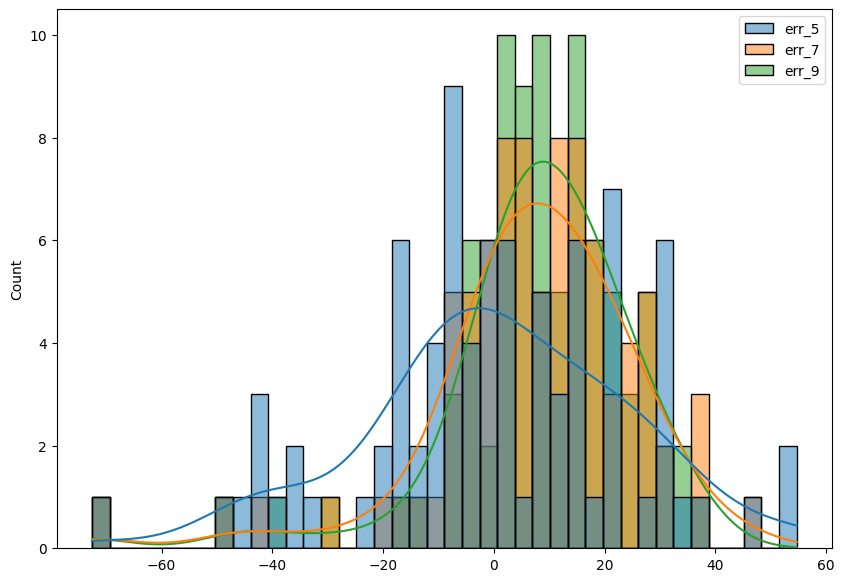

In [57]:
fig = plt.figure(figsize=(10,7))
sns.histplot(error_matrix,kde=True,bins=40)
plt.show()

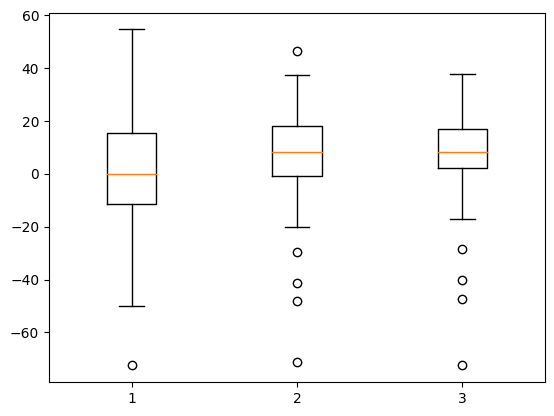

In [58]:
plt.boxplot(error_matrix)
plt.show()

In [59]:
errorMean = error_matrix.mean()
errorMean

err_5    0.416941
err_7    7.293412
err_9    8.132941
dtype: float64

In [60]:
errorMean = error_matrix.median()
errorMean

err_5    0.10
err_7    8.38
err_9    8.34
dtype: float64

In [61]:
errorSD = error_matrix.std()
errorSD

err_5    23.820435
err_7    18.130991
err_9    17.142710
dtype: float64

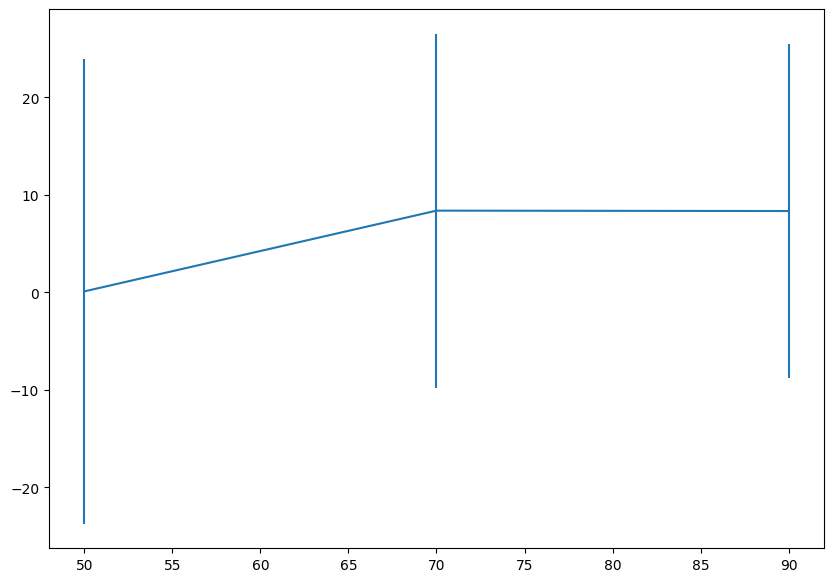

In [62]:
fig = plt.figure(figsize=(10,7))
plt.errorbar(x=[50, 70, 90], y=errorMean, yerr = errorSD)
plt.show()